Import necessary libraries

In [50]:
import torch
from torch import nn
from torch.optim import *
from torchvision.datasets import *
from torchvision.transforms import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


Define the ResNet18 model

In [51]:
from torchvision.models import resnet18

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.model = resnet18(pretrained=False)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.model(x)

model = ResNet18().cuda()  # Move model to GPU


/home/akshat_gosain/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/akshat_gosain/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


 Define the pruning function

In [52]:
def prune_by_magnitude(weight, sparsity):
    weight = weight.clone()
    threshold = torch.quantile(weight.abs(), sparsity)
    mask = weight.abs() >= threshold
    weight *= mask
    return weight


Define the weight distribution plotting function

In [53]:
def plot_weight_distribution(weight):
    plt.hist(weight.detach().cpu().numpy().flatten(), bins=100)
    plt.show()


Define the sparsity and model size calculation functions

In [54]:
def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()

def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements

def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width


Load the CIFAR-10 dataset

In [55]:
# Use more advanced data augmentation
transforms = {
    "train": Compose([
        RandomCrop(32, padding=4),
        RandomHorizontalFlip(),
        RandomRotation(15),  # Increase the range of rotation
        ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Increase the range of color jitter
        RandomGrayscale(p=0.1),  # Occasionally convert the image to grayscale
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "test": Compose([
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
}

dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=128,  # Reduced batch size
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )


Files already downloaded and verified
Files already downloaded and verified


Train the model

In [56]:
from torch.utils.data import random_split

# Split the training dataset into training and validation sets
train_dataset = dataset['train']
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create dataloaders for the training and validation sets
batch_size = 128  # Reduced batch size
dataloader = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True),
    'test': dataloader['test']  # Use the existing test dataloader
}

def calculate_validation_loss(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs = inputs.cuda()
        targets = targets.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)

def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer
    optimizer.step()

# Use the Adam optimizer with weight decay for regularization
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Use a learning rate schedule
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# Early stopping parameters
min_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement before stopping
patience_counter = 0

# Training loop with early stopping
num_epochs = 30
for epoch in range(num_epochs):
    train(model, dataloader['train'], criterion, optimizer)
    
    # Calculate validation loss here
    val_loss = calculate_validation_loss(model, dataloader['val'], criterion)
    
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss}')

    # Check if the validation loss improved
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    # If the validation loss didn't improve for 'patience' epochs, stop training
    if patience_counter >= patience:
        print('Early stopping')
        break

    scheduler.step()  # Update the learning rate




Epoch 1, Validation Loss: 1.5980566207885742


Epoch 2, Validation Loss: 1.4274694328308106


Epoch 3, Validation Loss: 1.2519183380126953


Epoch 4, Validation Loss: 1.1962423076629638


Epoch 5, Validation Loss: 1.122771204471588


Epoch 6, Validation Loss: 1.2182979055404664


Epoch 7, Validation Loss: 1.0861180271148683


Epoch 8, Validation Loss: 1.081627858543396


Epoch 9, Validation Loss: 1.005495212173462


Epoch 10, Validation Loss: 1.0481753971099854


Epoch 11, Validation Loss: 0.7883989961624146


Epoch 12, Validation Loss: 0.7745284922122956


Epoch 13, Validation Loss: 0.7694675538539887


Epoch 14, Validation Loss: 0.752157072019577


Epoch 15, Validation Loss: 0.7504107033729553


Epoch 16, Validation Loss: 0.7335411947250366


Epoch 17, Validation Loss: 0.7384646720886231


Epoch 18, Validation Loss: 0.7206340542793274


Epoch 19, Validation Loss: 0.7245517621040344


Epoch 20, Validation Loss: 0.7202747036457062


Epoch 21, Validation Loss: 0.706933575630188


Epoch 22, Validation Loss: 0.7019557900428772


Epoch 23, Validation Loss: 0.6899859300613403


Epoch 24, Validation Loss: 0.6921854063987732


Epoch 25, Validation Loss: 0.7046090785026551


Epoch 26, Validation Loss: 0.6954774549484253


Epoch 27, Validation Loss: 0.6890462143898011


Epoch 28, Validation Loss: 0.688777122926712


Epoch 29, Validation Loss: 0.6851420113563538


Epoch 30, Validation Loss: 0.6889900310516357


Epoch 31, Validation Loss: 0.6892713212013245


Epoch 32, Validation Loss: 0.7000141736984253


Epoch 33, Validation Loss: 0.6918634969711304


Epoch 34, Validation Loss: 0.6864180216789245


Epoch 35, Validation Loss: 0.6849706094741821


Epoch 36, Validation Loss: 0.6894502029418945


Epoch 37, Validation Loss: 0.6890621349334717


Epoch 38, Validation Loss: 0.7030488964080811


Epoch 39, Validation Loss: 0.6858342175483704


Epoch 40, Validation Loss: 0.6887791582584382


Epoch 41, Validation Loss: 0.6913894713401795


Epoch 42, Validation Loss: 0.696464801454544


Epoch 43, Validation Loss: 0.6889218341827392


Epoch 44, Validation Loss: 0.6873220248222351


Epoch 45, Validation Loss: 0.6881461631774902


Epoch 46, Validation Loss: 0.6818331997871399


Epoch 47, Validation Loss: 0.6872636083126068


Epoch 48, Validation Loss: 0.6949815683364868


Epoch 49, Validation Loss: 0.688779963684082


Epoch 50, Validation Loss: 0.68468088722229


Epoch 51, Validation Loss: 0.6965370122909545


Epoch 52, Validation Loss: 0.6902158297538757


Epoch 53, Validation Loss: 0.6845986402511597


Epoch 54, Validation Loss: 0.6829093545913696


Epoch 55, Validation Loss: 0.6809010591506958


Epoch 56, Validation Loss: 0.6903800652503967


Epoch 57, Validation Loss: 0.6880390852451325


Epoch 58, Validation Loss: 0.6840665570735931


Epoch 59, Validation Loss: 0.6872946851730347


Epoch 60, Validation Loss: 0.6917928311347962


Epoch 61, Validation Loss: 0.6994807817459107


Epoch 62, Validation Loss: 0.6782905244827271


Epoch 63, Validation Loss: 0.6947181586742401


Epoch 64, Validation Loss: 0.6971408030509949


Epoch 65, Validation Loss: 0.690646937084198


Epoch 66, Validation Loss: 0.6838493242263793


Epoch 67, Validation Loss: 0.6873126230716705


Epoch 68, Validation Loss: 0.6929142769813538


Epoch 69, Validation Loss: 0.6813269886016846


Epoch 70, Validation Loss: 0.6851481236457825


Epoch 71, Validation Loss: 0.6858994893550873


Epoch 72, Validation Loss: 0.6930539522171021


Epoch 73, Validation Loss: 0.6793665752410889


Epoch 74, Validation Loss: 0.6736249650001526


Epoch 75, Validation Loss: 0.6902443356990814


Epoch 76, Validation Loss: 0.678020793056488


Epoch 77, Validation Loss: 0.6765220874786377


Epoch 78, Validation Loss: 0.6874602785110474


Epoch 79, Validation Loss: 0.6879611214637756


Epoch 80, Validation Loss: 0.6991579473495484


Epoch 81, Validation Loss: 0.684622968006134


Epoch 82, Validation Loss: 0.6848954851150513


Epoch 83, Validation Loss: 0.6880366978168487


Epoch 84, Validation Loss: 0.6800489227771759


Epoch 85, Validation Loss: 0.6851802555084229


Epoch 86, Validation Loss: 0.693580676651001


Epoch 87, Validation Loss: 0.687296255350113


Epoch 88, Validation Loss: 0.6968533380508423


Epoch 89, Validation Loss: 0.6869755883693696


Epoch 90, Validation Loss: 0.6874826845645905


Epoch 91, Validation Loss: 0.691637578010559


Epoch 92, Validation Loss: 0.6924348299980163


Epoch 93, Validation Loss: 0.6803879593849183


Epoch 94, Validation Loss: 0.6904369663715363
Early stopping


Test the model

In [57]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

accuracy = evaluate(model, dataloader['test'])
print(f'Accuracy of the network on the 10000 test images: {accuracy}%')


eval:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 80.83999633789062%


In [58]:
import torch.nn.utils.prune as prune

# Let's say `layer` is the layer you want to prune
parameters_to_prune = (
    (model.model.layer1[0].conv1, 'weight'),
    (model.model.layer1[0].conv2, 'weight'),
    (model.model.layer1[1].conv1, 'weight'),
    (model.model.layer1[1].conv2, 'weight'),
    # add more layers here
)

for sparsity in [0.1, 0.2, 0.3, 0.4, 0.5]:
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=sparsity,
    )
    # Evaluate the model here and record its performance


In [59]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

accuracy = evaluate(model, dataloader['test'])
print(f'Accuracy of the network on the 10000 test images: {accuracy}%')


Accuracy of the network on the 10000 test images: 56.22999572753906%


In [60]:
# Let's say `layer` is the layer you want to prune
parameters_to_prune = (
    (model.model.layer1[0].conv1, 'weight'),
    (model.model.layer1[0].conv2, 'weight'),
    (model.model.layer1[1].conv1, 'weight'),
    (model.model.layer1[1].conv2, 'weight'),
    # add more layers here
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,  # replace with the sparsity level you chose for this layer
)


In [66]:
# Fine-tuning the pruned model
num_epochs = 100
for epoch in range(num_epochs):
    train(model, dataloader['train'], criterion, optimizer)
    
    # Calculate validation loss here
    val_loss = calculate_validation_loss(model, dataloader['val'], criterion)
    
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss}')

    # Check if the validation loss improved
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    # If the validation loss didn't improve for 'patience' epochs, stop training
    if patience_counter >= patience:
        print('Early stopping')
        break

    scheduler.step()  # Update the learning rate


Epoch 1, Validation Loss: 1.0053582515716553
Early stopping


Prune the model

In [63]:
def prune_by_magnitude(weight, sparsity):
    weight = weight.clone()
    # Sort the tensor
    sorted_weights = torch.sort(weight.abs().flatten())[0]
    # Compute the index of the threshold
    index = int(sparsity * sorted_weights.numel())
    # Select the value at the computed index
    threshold = sorted_weights[index]
    mask = weight.abs() >= threshold
    weight *= mask
    return weight

for name, param in model.named_parameters():
    if 'weight' in name:
        param.data = prune_by_magnitude(param.data, 0.2)  # Prune 20% of the weights


Fine-tune the pruned model

In [67]:
for epoch in range(10):  # loop over the dataset multiple times
    train(model, dataloader['train'], criterion, optimizer)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss}')


Epoch 1, Validation Loss: 1.0053582515716553


Epoch 2, Validation Loss: 1.0053582515716553


Epoch 3, Validation Loss: 1.0053582515716553


Epoch 4, Validation Loss: 1.0053582515716553


Epoch 5, Validation Loss: 1.0053582515716553


Epoch 6, Validation Loss: 1.0053582515716553


KeyboardInterrupt: 

Test the pruned model

In [62]:
accuracy = evaluate(model, dataloader['test'])
print(f'Accuracy of the pruned network on the 10000 test images: {accuracy}%')


Accuracy of the pruned network on the 10000 test images: 75.87999725341797%


Plot the weight distribution

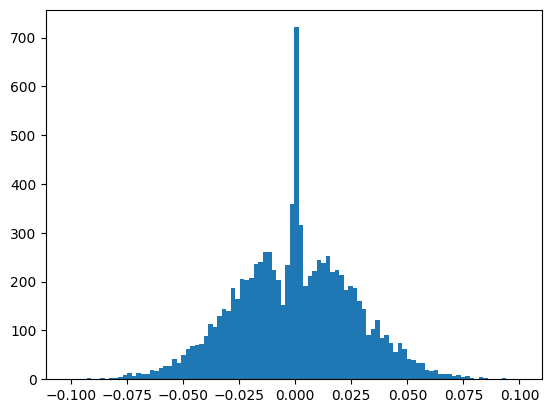

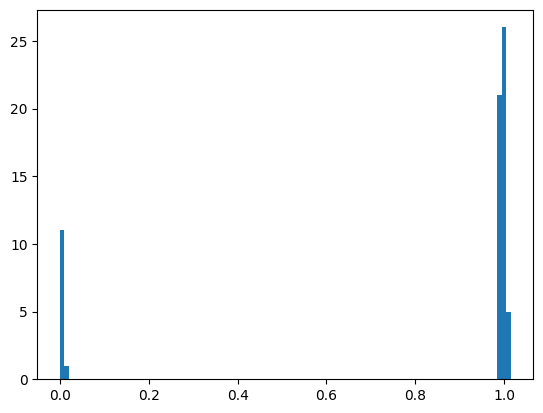

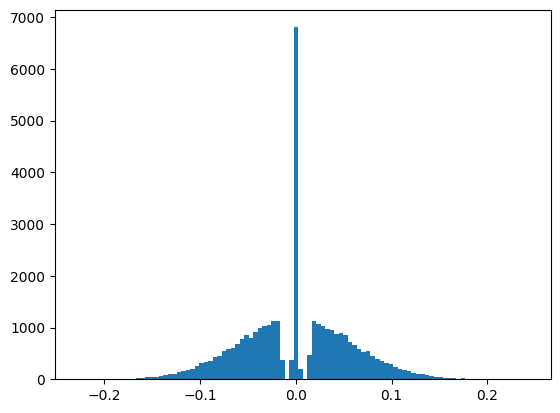

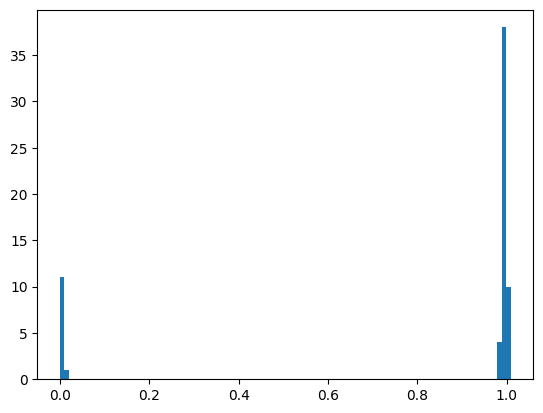

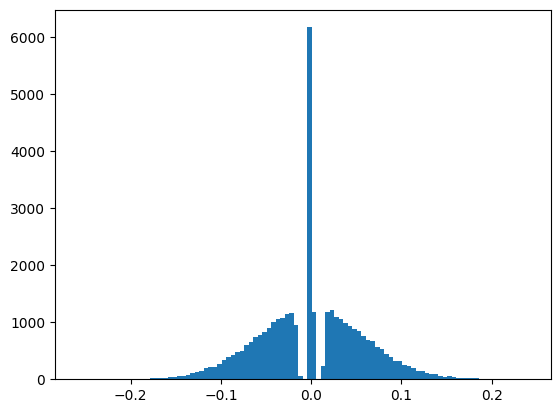

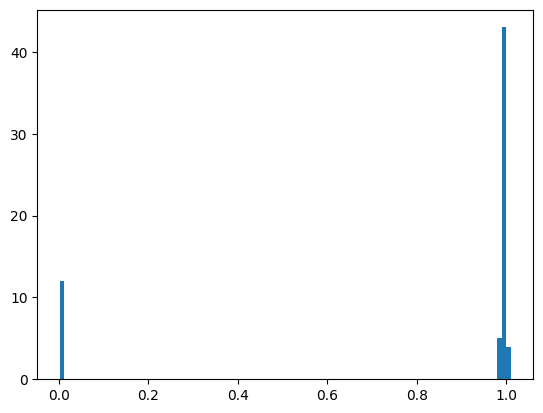

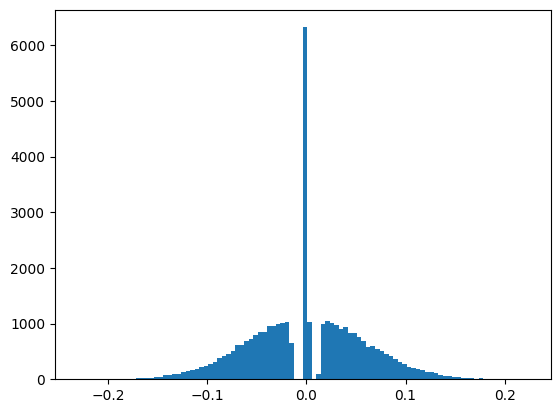

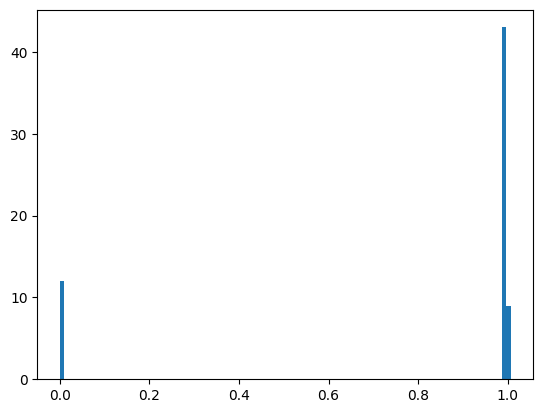

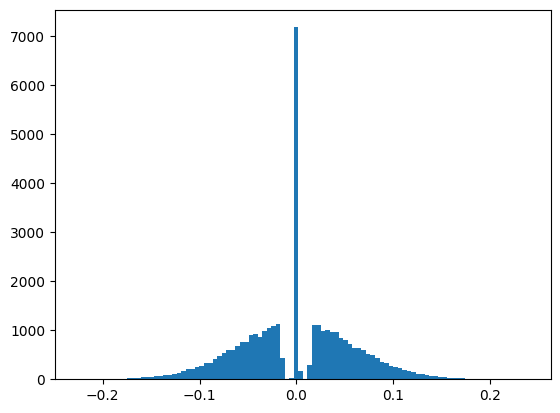

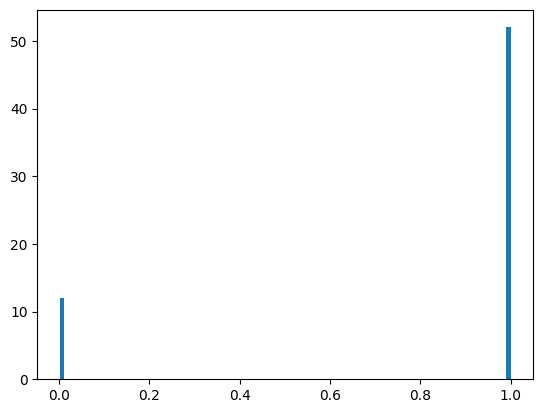

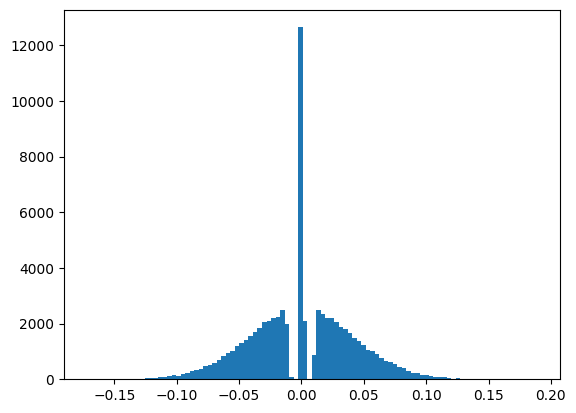

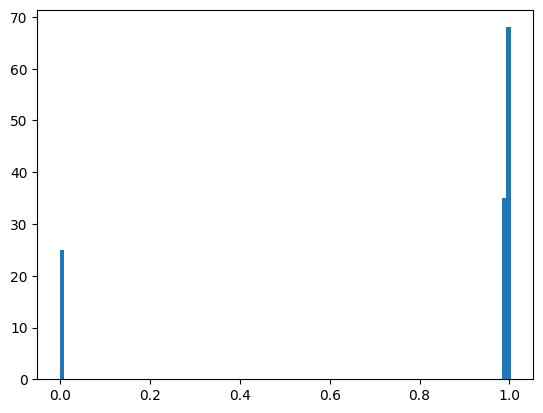

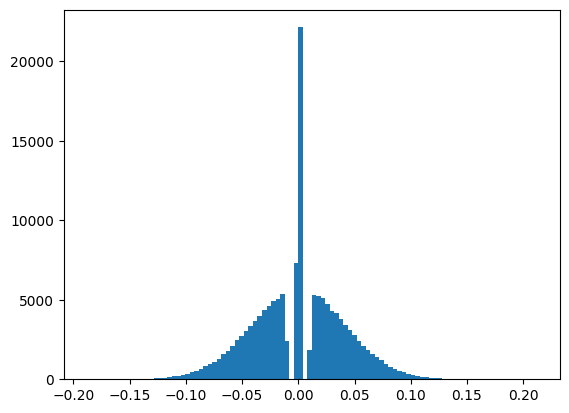

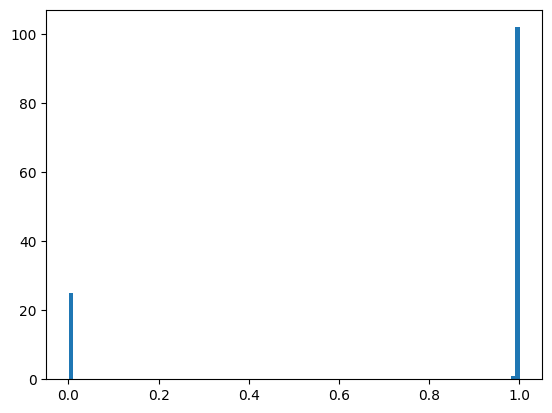

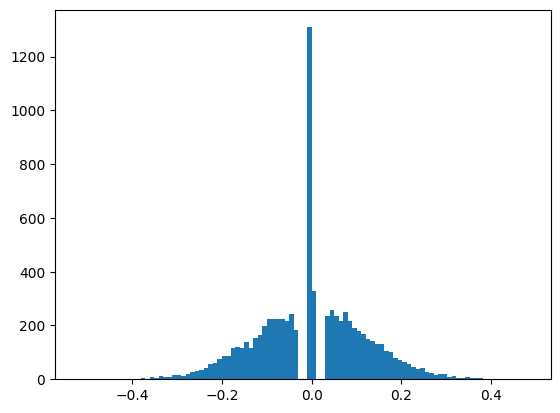

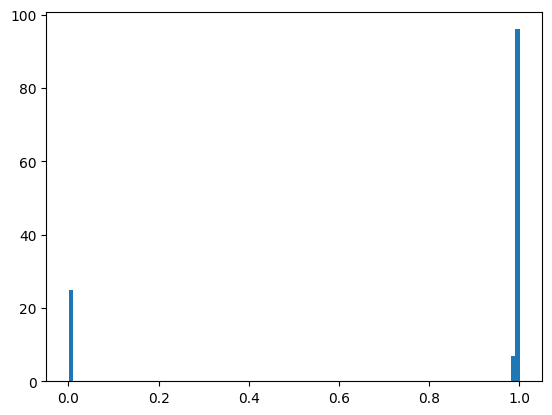

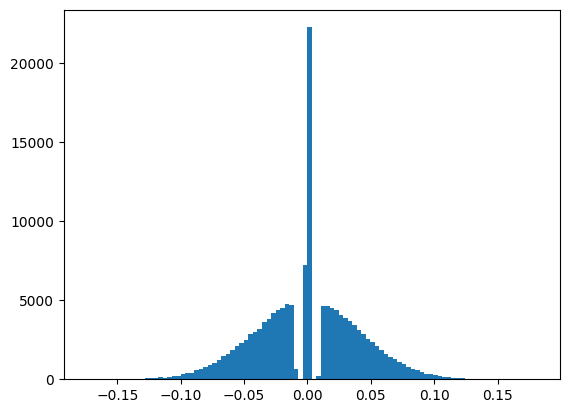

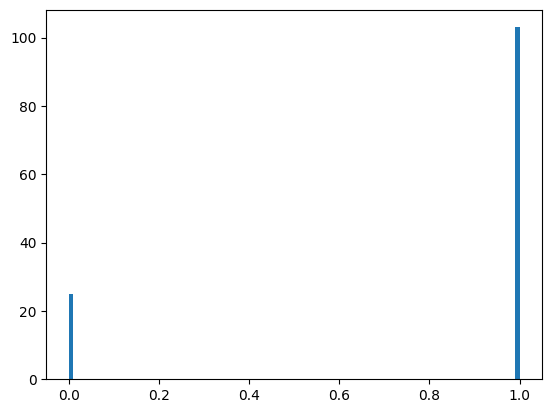

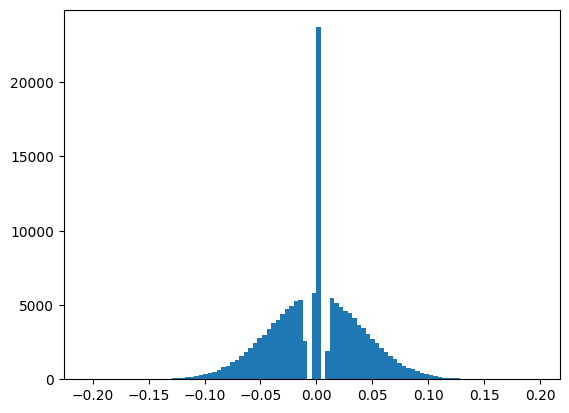

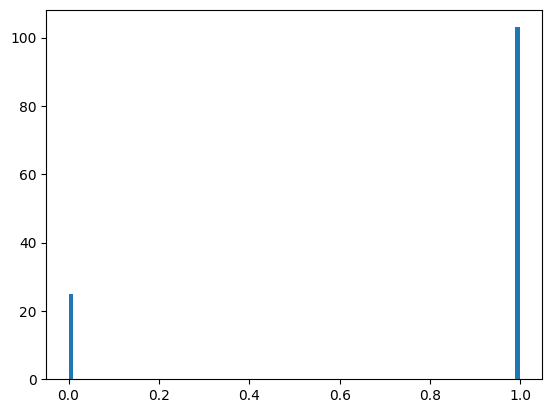

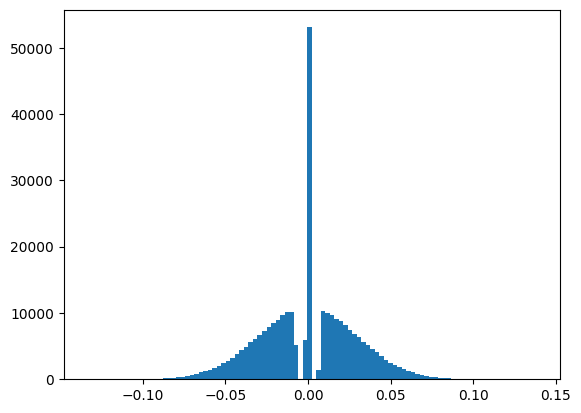

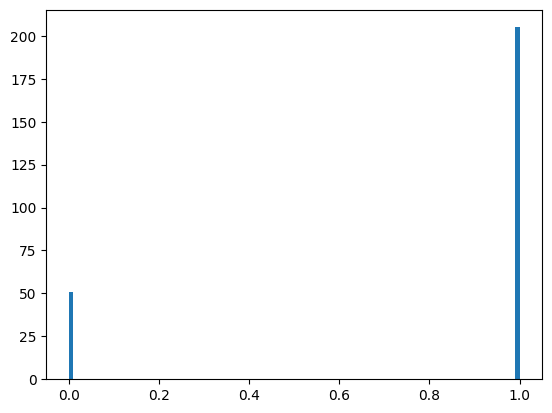

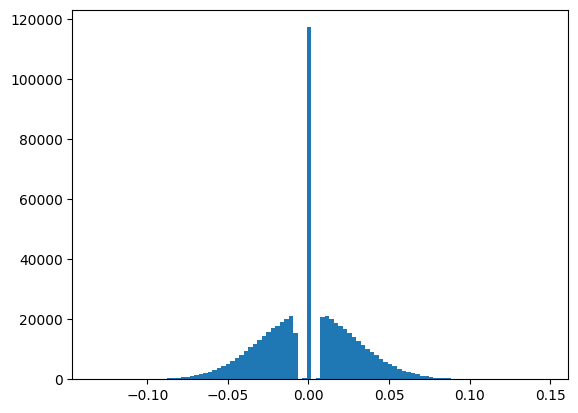

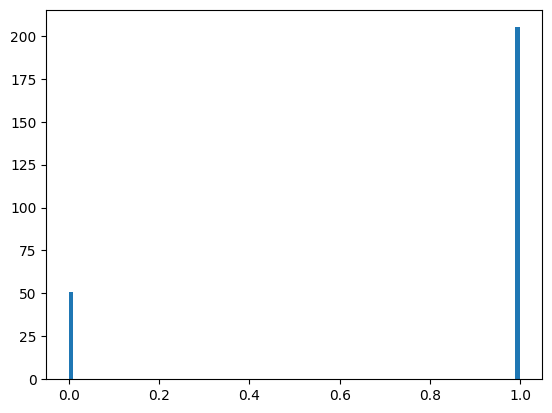

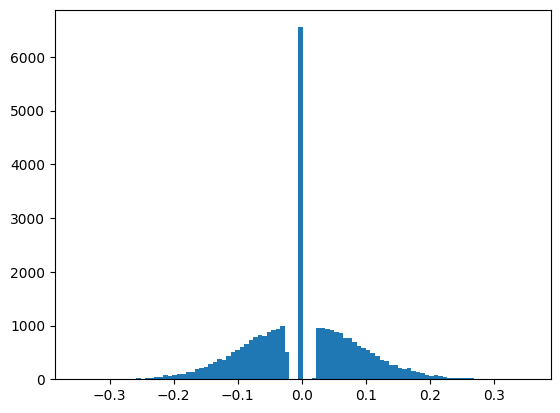

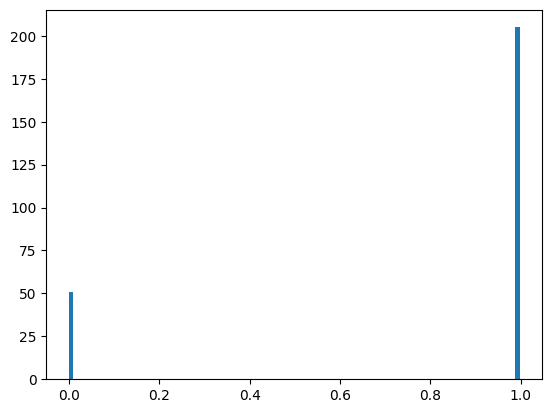

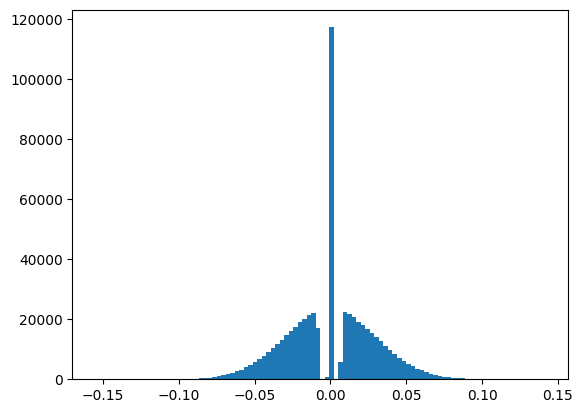

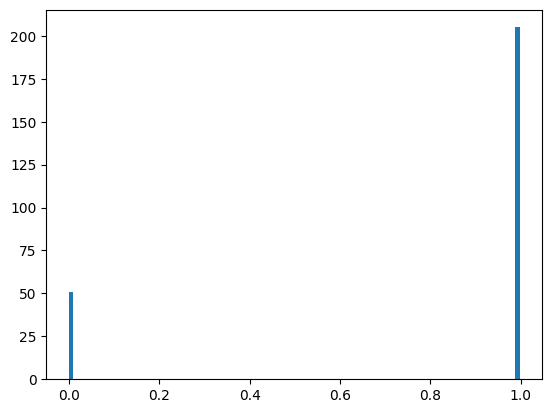

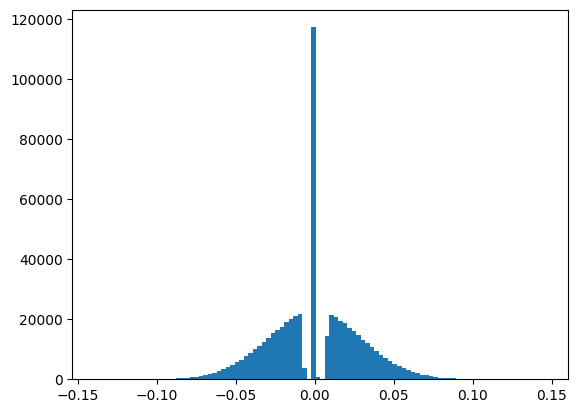

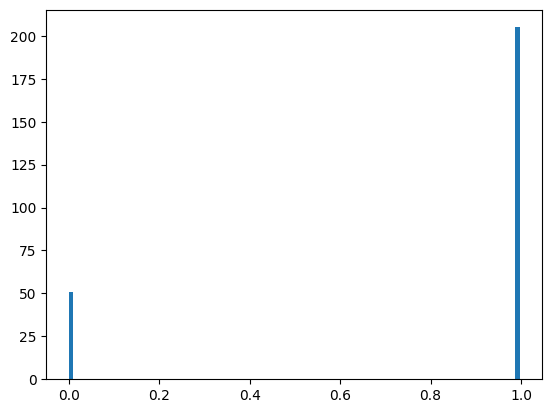

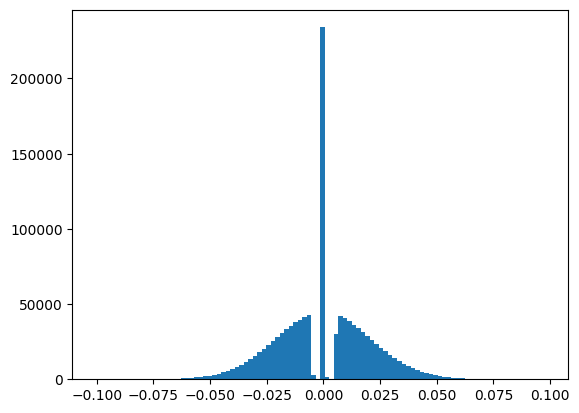

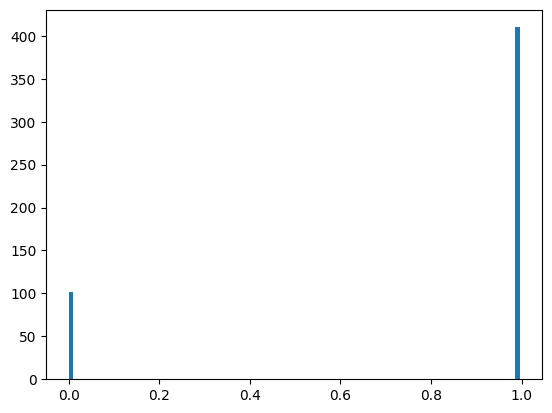

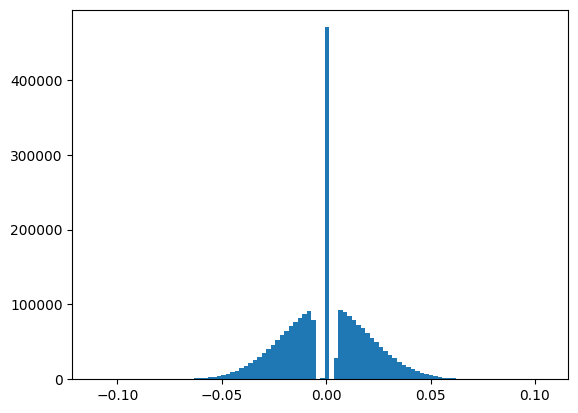

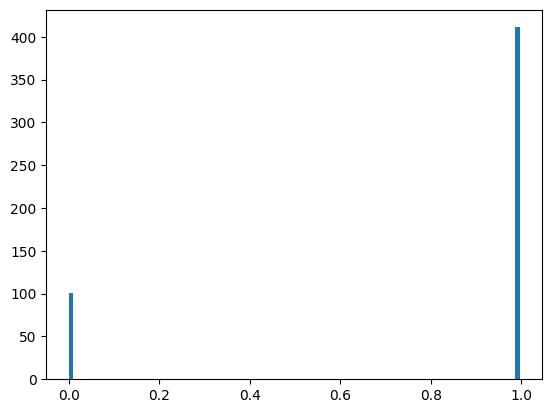

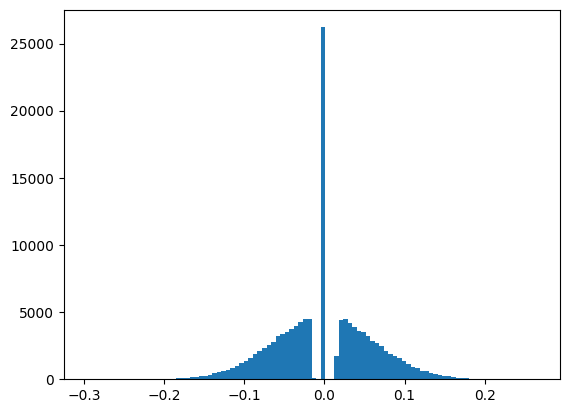

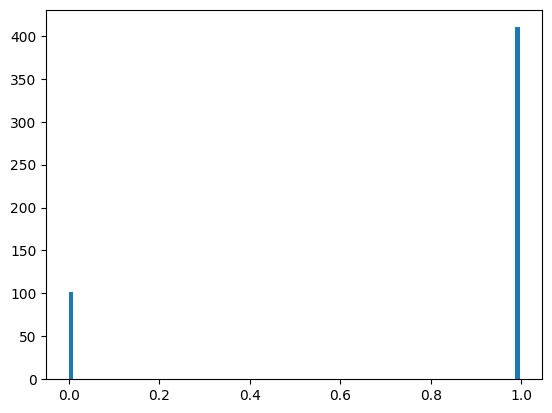

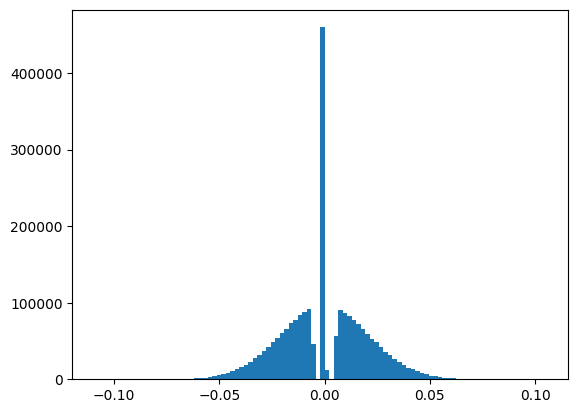

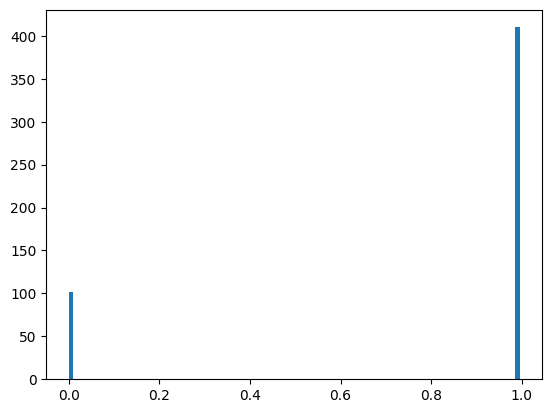

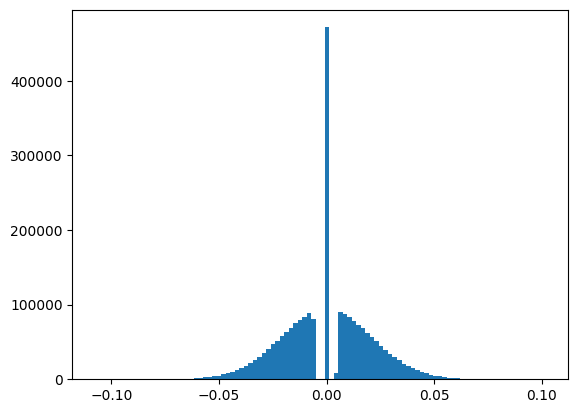

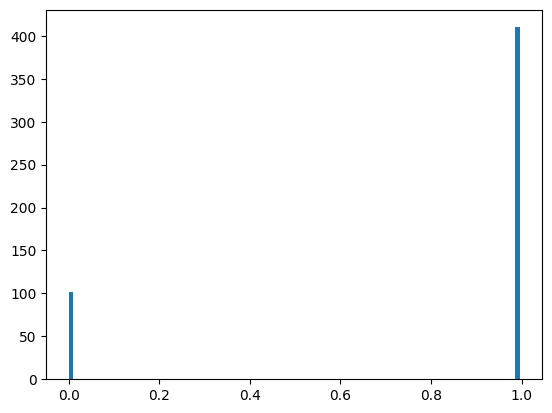

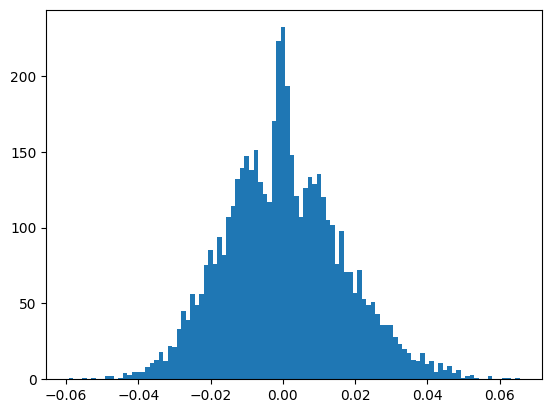

In [12]:
for name, param in model.named_parameters():
    if 'weight' in name:
        plot_weight_distribution(param.data)


Calculate and print the sparsity and size of the model

In [13]:
sparsity = get_model_sparsity(model)
size = get_model_size(model)
print(f'Sparsity of the model: {sparsity}')
print(f'Size of the model: {size} bits')


Sparsity of the model: 0.0
Size of the model: 357812544 bits
